<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvision_ResNet101_TransferLearning_Inagi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.ResNet101で転移学習・推論

参考にしたサイト# https://tetsumag.com/2021/01/11/ml7/



## 1.1 Google Drive をマウント

In [ ]:
!cd /home/developer/dev

In [ ]:
!mkdir test_dir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
from tqdm import tqdm
from PIL import Image

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## 1.3 各種準備

In [4]:
# transformsを定義
size = (224, 224)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# datasetsを定義
train_data_dir = 'dataset/train'
val_data_dir = 'dataset/val'

image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_data_dir, transform=data_transforms['train']),
    'val': torchvision.datasets.ImageFolder(val_data_dir, transform=data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=5)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val'])
}

class_names = image_datasets['train'].classes
print('分類種類:', class_names)


分類種類: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger', 'aoi-shrine', 'gym', 'monument', 'pump', 'shrine', 'stone', 'temple']


#### 1.4 モデルの調整

In [6]:
# モデルの調整

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ResNet101の読み込み
model = models.resnet101(pretrained=True)

# パラメータの固定
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層を固定しない＞ここだけ学習する
last_layer = list(model.children())[-1]
for param in last_layer.parameters():
    param.requires_grad = True

# 分類数を1000から2つに変更
#num_ftrs = model.classifier[6].in_features
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# loss関数、最適化関数の設定
# lossを定義
criterion = nn.CrossEntropyLoss()

# 色々な最適化関数 lrが学習率 0.001 0.0001などで調整
optimizer = optim.Adam(model.parameters(), lr=0.0001,)
# optimizer = optim.SGD(model.parameters(), lr=0.001,)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

## 1.5 学習処理関数

In [10]:
# 学習処理
def train(model, dataloader, otpimizer, criterion, num_epochs, device):
    """
    model:学習モデル
    dataloader:学習、評価データのdataloader
    optimizer:最適化関数
    crierion:ロス関数
    num_epochs:学習回数
    device:CPUかGPUか
    """
    best_acc = 0.0
    # 学習を繰り返す
    for epoch in range(num_epochs):
        # trainとvalを繰り返す
        for phase in ['train', 'val']:
            # モデルを学習モードか評価モードに切り替える
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 精度計算用
            loss_sum = 0.0
            acc_sum = 0.0
            total = 0

            # 進捗の表示
            with tqdm(total=len(dataloaders[phase]),unit="batch") as pbar:
                pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                
                # dataloadersからバッチサイズに応じてデータを取得
                for inputs, labels in dataloaders[phase]:
                    # 画像とラベルをGPU/CPUか切り替え
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 予測
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # ロス算出
                    loss = criterion(outputs, labels)
                    
                    # 予測とラベルの差を使って学習 
                    if phase == 'train':
                        # ここは決まり文句
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # ロス、精度を算出
                    total += inputs.size(0)
                    loss_sum += loss.item() * inputs.size(0)
                    acc_sum += torch.sum(preds == labels.data).item()
                    
                    # 進捗の表示
                    pbar.set_postfix({"loss":loss_sum/float(total),"accuracy":float(acc_sum)/float(total)})
                    pbar.update(1)

            # 1エポックでのロス、精度を算出
            epoch_loss = loss_sum / dataset_sizes[phase]
            epoch_acc = acc_sum / dataset_sizes[phase]
            
            # 一番良い制度の時にモデルデータを保存
            if phase == 'val' and epoch_acc > best_acc:
                print(f"save model epoch:{epoch} loss:{epoch_loss} acc:{epoch_acc}")
                torch.save(model, 'best_model_resnet101_tl20210906.pth')



## 1.6 学習実行

In [11]:
# 関数を実行
##num_epochs = 10
num_epochs = 15
train(model, dataloaders, optimizer, criterion, num_epochs, device)


Epoch[0/15](val): 100%|██████████| 33/33 [00:42<00:00,  1.28s/batch, loss=1.75, accuracy=0.642]


save model epoch:0 loss:1.7480610392310403 acc:0.6424242424242425


Epoch[1/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.73batch/s, loss=1.23, accuracy=0.927]


save model epoch:1 loss:1.2302987467158923 acc:0.9272727272727272


Epoch[2/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.76batch/s, loss=0.874, accuracy=0.952]


save model epoch:2 loss:0.8737214821757693 acc:0.9515151515151515


Epoch[3/15](val): 100%|██████████| 33/33 [00:05<00:00,  6.56batch/s, loss=0.657, accuracy=0.964]


save model epoch:3 loss:0.656865021496108 acc:0.9636363636363636


Epoch[4/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.73batch/s, loss=0.535, accuracy=0.952]


save model epoch:4 loss:0.535261331634088 acc:0.9515151515151515


Epoch[5/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.76batch/s, loss=0.427, accuracy=0.964]


save model epoch:5 loss:0.4267761174476508 acc:0.9636363636363636


Epoch[6/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.71batch/s, loss=0.365, accuracy=0.958]


save model epoch:6 loss:0.3646127105210767 acc:0.9575757575757575


Epoch[7/15](val): 100%|██████████| 33/33 [00:05<00:00,  6.53batch/s, loss=0.328, accuracy=0.964]


save model epoch:7 loss:0.32762837037444115 acc:0.9636363636363636


Epoch[8/15](val): 100%|██████████| 33/33 [00:05<00:00,  6.58batch/s, loss=0.296, accuracy=0.976]


save model epoch:8 loss:0.2955068656892488 acc:0.9757575757575757


Epoch[9/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.67batch/s, loss=0.254, accuracy=0.97]


save model epoch:9 loss:0.2542094242843715 acc:0.9696969696969697


Epoch[10/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.69batch/s, loss=0.228, accuracy=0.976]


save model epoch:10 loss:0.22783604388435683 acc:0.9757575757575757


Epoch[11/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.73batch/s, loss=0.212, accuracy=0.97]


save model epoch:11 loss:0.21183528570514737 acc:0.9696969696969697


Epoch[12/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.75batch/s, loss=0.212, accuracy=0.976]


save model epoch:12 loss:0.2122466525796688 acc:0.9757575757575757


Epoch[13/15](val): 100%|██████████| 33/33 [00:05<00:00,  6.58batch/s, loss=0.184, accuracy=0.976]


save model epoch:13 loss:0.18392676775428382 acc:0.9757575757575757


Epoch[14/15](val): 100%|██████████| 33/33 [00:04<00:00,  6.61batch/s, loss=0.193, accuracy=0.97]


save model epoch:14 loss:0.19280826018163652 acc:0.9696969696969697


## 1.7 推論

torch.Size([12])
[0.00321546 0.00363561 0.00400851 0.00229336 0.00306718 0.00734594
 0.9064861  0.00319183 0.0256352  0.02316286 0.00217676 0.01578125]
gym


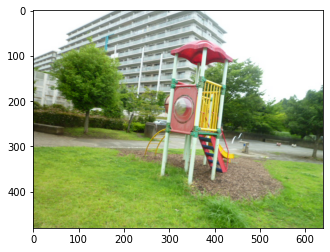

In [13]:
# テストデータで確認
# 今回学習したモデルでテスト
best_model = torch.load('best_model_resnet101_tl20210906.pth')

# 対象画像
filename = 'dataset/test.jpg'
#filename = 'dataset/monument.JPG'
#filename = 'dataset/pump.JPG'

# 読み込み画像をリサイズやtensorなどの方に変換
input_image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# GPU使える場合はGPUを使う
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    best_model.to('cuda')

# AIの判定
with torch.no_grad():
    output = best_model(input_batch)
output = torch.nn.functional.softmax(output[0], dim=0)
print(output.shape)

# 出力結果から2種類のうちどれかを数値で取得
output = output.to('cpu').detach().numpy().copy()
ind = np.argmax(output)
print(output)
print(class_names[ind])

%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename),cmap="gray")